# Part 1: Data import and preparation



In [1]:
# Import the modules necessary for the program


import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cartopy.feature import ShapelyFeature
import cartopy.crs as ccrs
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from shapely.geometry import Point, LineString, Polygon

%matplotlib inline
plt.ion()

In [2]:
#Import the different data files used for the analyses

flood= gpd.read_file(os.path.abspath('Project_datafiles/Flood_2m.shp'))
roads= gpd.read_file(os.path.abspath('Project_datafiles/Fermanagh_roads.shp'))
buildings= gpd.read_file(os.path.abspath('Project_datafiles/Building_Fermanagh.shp'))
pop_demography=gpd.read_file(os.path.abspath('Project_datafiles/popdemography.csv'))
outline = gpd.read_file(os.path.abspath('Project_datafiles/Fermanagh_DCA.shp'))
small_area= gpd.read_file(os.path.abspath('Project_datafiles/SApoly.shp'))
land_cover= gpd.read_file(os.path.abspath('Project_datafiles/LC_Fermanagh.shp'))

In [3]:
# Creates matplotlib handles which will be used to create a legend of the features added on the maps
def generate_handles(labels, colors, edge='k', alpha=1):
    lc = len(colors)  
    handles = []
    for i in range(len(labels)):
        handles.append(mpatches.Rectangle((0, 0), 1, 1, facecolor=colors[i % lc], edgecolor=edge, alpha=alpha))
    return handles

In [4]:
# Creates a scale (with a division at 0,5 and 10m)  located in the upper right corner
def scale_bar(ax, location=(0.32, 0.95)):
    x0, x1, y0, y1 = ax.get_extent()
    sbx = x0 + (x1 - x0) * location[0]
    sby = y0 + (y1 - y0) * location[1]

    ax.plot([sbx, sbx - 10000], [sby, sby], color='k', linewidth=9, transform=ax.projection)
    ax.plot([sbx, sbx - 5000], [sby, sby], color='k', linewidth=6, transform=ax.projection)
    ax.plot([sbx-5000, sbx - 10000], [sby, sby], color='w', linewidth=6, transform=ax.projection)

    ax.text(sbx, sby-1000, '10 km', transform=ax.projection, fontsize=10)
    ax.text(sbx-5000, sby-1000, '5 km', transform=ax.projection, fontsize=10)
    ax.text(sbx-10000, sby-1000, '0 km', transform=ax.projection, fontsize=10)


In [5]:
# Create a function to subset the shapefiles based on the flood polygon
def flooded(shapefile):
    flood_geom = flood['geometry'].values[0]
    flooded = shapefile['geometry'].within(flood_geom)
    return shapefile['geometry'].within(flood_geom)


In [6]:
#Merge the pop_demography csv with the small_area shapefile using the SA2011 column as the common column
small_area =gpd.GeoDataFrame(pop_demography.merge(small_area, on="SA2011"))
small_area.head()

,SA2011,residents,children,elderly,geometry_x,SOA2011,X_COORD,Y_COORD,Hectares,Shape_Leng,Shape_Area,geometry_y
0,N00002840,1431,206,170,None,95OO09W1,254975.0,348366.0,6501.2300,1165.959442,8.887880e+03,"POLYGON ((252811.562 343516.812, 252805.719 34..."
1,N00002875,1081,139,201,None,95OO16W1,245853.0,352166.0,4642.3600,16465.931517,2.435332e+05,"MULTIPOLYGON (((243534.693 349935.659, 243523...."
2,N00002876,531,78,63,None,95OO16W1,248710.0,346505.0,3133.7100,24116.723771,1.552702e+05,"MULTIPOLYGON (((249689.520 342125.283, 249724...."
3,N00002878,205,17,54,None,95OO16W1,243822.0,347918.0,41.5643,1432.148481,1.148343e+04,"POLYGON ((243255.547 348262.219, 243259.156 34..."
4,N00002912,345,38,69,None,95PP01W1,225525.0,348857.0,1255.1600,26671.860028,1.255163e+07,"POLYGON ((227161.047 350213.156, 227161.109 35..."


In [7]:
#Set the geometry column and edit the column name to geometry
small_area.rename(columns={'geometry_y':'geometry'}, inplace=True)

small_area.set_geometry('geometry')

,SA2011,residents,children,elderly,geometry_x,SOA2011,X_COORD,Y_COORD,Hectares,Shape_Leng,Shape_Area,geometry
0,N00002840,1431,206,170,None,95OO09W1,254975.0,348366.0,6501.2300,1165.959442,8.887880e+03,"POLYGON ((252811.562 343516.812, 252805.719 34..."
1,N00002875,1081,139,201,None,95OO16W1,245853.0,352166.0,4642.3600,16465.931517,2.435332e+05,"MULTIPOLYGON (((243534.693 349935.659, 243523...."
2,N00002876,531,78,63,None,95OO16W1,248710.0,346505.0,3133.7100,24116.723771,1.552702e+05,"MULTIPOLYGON (((249689.520 342125.283, 249724...."
3,N00002878,205,17,54,None,95OO16W1,243822.0,347918.0,41.5643,1432.148481,1.148343e+04,"POLYGON ((243255.547 348262.219, 243259.156 34..."
4,N00002912,345,38,69,None,95PP01W1,225525.0,348857.0,1255.1600,26671.860028,1.255163e+07,"POLYGON ((227161.047 350213.156, 227161.109 35..."
...,...,...,...,...,...,...,...,...,...,...,...,...
162,N00004441,550,74,57,None,95YY21W1,229920.0,357951.0,1832.3300,4692.957044,2.793306e+04,"MULTIPOLYGON (((228974.460 355263.986, 228974...."
163,N00004442,545,89,69,None,95YY21W1,237867.0,357468.0,2612.6500,8305.400422,5.415938e+04,"MULTIPOLYGON (((237579.828 354628.375, 237579...."
164,N00004443,612,103,83,None,95YY21W1,234595.0,356093.0,2228.5100,5058.592762,2.032710e+04,"MULTIPOLYGON (((234708.016 352733.406, 234705...."
165,N00004445,405,70,61,None,95YY21W1,231610.0,353656.0,1466.9700,13909.298102,1.125557e+05,"MULTIPOLYGON (((231942.312 350909.781, 231924...."


In [8]:
# Set the columns data type to integer instead of string
small_area['residents'] = small_area['residents'].astype(int)
small_area['Shape_Area'] = small_area['Shape_Area'].astype(int)
small_area['elderly'] = small_area['elderly'].astype(int)
small_area['children'] = small_area['children'].astype(int)

In [9]:
# Create a population density, percentage of elderly and percentage of children columns and show the new geodatabase

for ind, row in small_area.iterrows(): 
    small_area.loc[ind, 'pop_density'] = row['residents']/ (row['Shape_Area']/ 1000000)

for ind, row in small_area.iterrows(): 
    small_area.loc[ind, 'per_elderly'] = row['elderly']/ row['residents']* 100
    
for ind, row in small_area.iterrows():
    small_area.loc[ind, 'per_children'] = row['children']/ row['residents']* 100
     
small_area.pop_density=small_area.pop_density.round()
small_area.per_children=small_area.per_children.round(2)
small_area.per_elderly=small_area.per_elderly.round(2)
print(small_area.head())

      SA2011  residents  children  elderly geometry_x   SOA2011   X_COORD   
0  N00002840       1431       206      170       None  95OO09W1  254975.0  \
1  N00002875       1081       139      201       None  95OO16W1  245853.0   
2  N00002876        531        78       63       None  95OO16W1  248710.0   
3  N00002878        205        17       54       None  95OO16W1  243822.0   
4  N00002912        345        38       69       None  95PP01W1  225525.0   

    Y_COORD   Hectares    Shape_Leng  Shape_Area   
0  348366.0  6501.2300   1165.959442        8887  \
1  352166.0  4642.3600  16465.931517      243533   
2  346505.0  3133.7100  24116.723771      155270   
3  347918.0    41.5643   1432.148481       11483   
4  348857.0  1255.1600  26671.860028    12551625   

                                            geometry  pop_density   
0  POLYGON ((252811.562 343516.812, 252805.719 34...     161022.0  \
1  MULTIPOLYGON (((243534.693 349935.659, 243523....       4439.0   
2  MULTIPOLYGON (

In [10]:
# Set the Geographic Coordinate system to the Irish Transverse Mercator for all shapefiles
flood.to_crs(epsg = 2157)
roads.to_crs(epsg = 2157)
buildings.to_crs(epsg = 2157)
outline.to_crs(epsg = 2157)
small_area.to_crs(epsg = 2157)
land_cover.to_crs(epsg = 2157)

,SEGID,TOTPIXELS,COREPIXELS,BHSUB,LAND_COVER,Shape_Leng,Shape_Area,geometry
0,H000009r1,1785,1040,6.1,Neutral grass,20700.000000,1.115625e+06,"POLYGON ((597303.594 849201.689, 597303.594 84..."
1,H000015r1,2031,1419,7.1,Calcareous grass,17300.000000,1.269375e+06,"POLYGON ((593529.434 854200.632, 593529.434 85..."
2,H000017r1,5148,3700,10.2,Open dwarf shrub heath,33365.445406,2.699577e+06,"POLYGON ((599078.292 864323.421, 599078.291 86..."
3,H000023r1,0,0,12.1,Bog,4630.182956,4.091334e+05,"MULTIPOLYGON (((624405.618 823638.054, 624405...."
4,H000025r1,0,0,12.1,Bog,5076.466263,2.692242e+05,"MULTIPOLYGON (((614628.752 828910.970, 614628...."
...,...,...,...,...,...,...,...,...
37831,H172275r1,23,17,16.1,Inland Bare Ground,700.000000,1.437500e+04,"POLYGON ((628854.899 868778.303, 628829.904 86..."
37832,H172276r1,23,5,10.2,Open dwarf shrub heath,750.000000,1.437500e+04,"POLYGON ((629354.791 868728.311, 629354.791 86..."
37833,H172277r1,34,7,10.2,Open dwarf shrub heath,1100.000000,2.125000e+04,"POLYGON ((629354.791 868728.311, 629329.796 86..."
37834,H172278r1,36,8,12.1,Bog,1050.000000,2.250000e+04,"POLYGON ((629454.769 868678.321, 629429.774 86..."


# Part 2: Landcover map and analyses

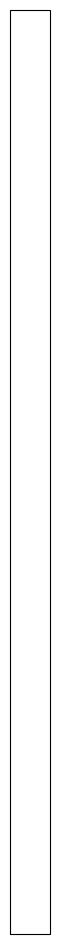

In [11]:
#Create a new figure set to the Irish Transverse Mercator

myFig = plt.figure(figsize=(12, 12))

myCRS = ccrs.UTM(29)  
ax = plt.axes(projection=myCRS) 

In [12]:
# Add the outline for Fermanagh County and zoom to the extent of the flood polygon
outline_feature = ShapelyFeature(outline['geometry'], myCRS, edgecolor='k', facecolor='w')
xmin, ymin, xmax, ymax = flood.total_bounds
ax.add_feature(outline_feature) # add the features we've created to the map.
ax.set_extent([xmin-1000, xmax+1000, ymin-1000, ymax+1000], crs=myCRS)


In [13]:
# Check the number of Landcover type present in the dataset and print the names
landcover= len(land_cover.LAND_COVER.unique())
print('Number of unique features: {}'.format(landcover))
list_landcover = list(land_cover.LAND_COVER.unique())
print(list_landcover) 

Number of unique features: 14
['Neutral grass', 'Calcareous grass', 'Open dwarf shrub heath', 'Bog', 'Improved grassland', 'Coniferous woodland', 'Acid grass', 'Dwarf shrub heath', 'Broad-leaved woodland', 'Fen, marsh, swamp', 'Inland Bare Ground', 'Arable horticulture', 'Suburban/rural developed', 'Continuous Urban']


In [14]:
# Assign a color for each landcover type  and add the feature to the map
land_cover_colors = ['springgreen','olive', 'sienna','darkred', 'lawngreen', 'forestgreen','yellowgreen', 'y','darkgreen','darkorange','lightgrey','gold','black','grey']
landcover=list(land_cover.LAND_COVER.unique())
for ii, name in enumerate(landcover):
    feat = ShapelyFeature(land_cover.loc[land_cover['LAND_COVER'] == name, 'geometry'], # first argument is the geometry
                          myCRS, # second argument is the CRS
                          edgecolor='k', # outline the feature in black
                          facecolor=land_cover_colors[ii],
                        linewidth=0.1,
                         alpha=0.8) # set the face color to the corresponding color from the list
                           # set the outline width to be 1 pt
                           # set the alpha (transparency) to be 0.25 (out of 1)
    ax.add_feature(feat)


In [15]:
# Add the flood polygon to the map
flood_feature = ShapelyFeature(flood['geometry'], myCRS, edgecolor='r',facecolor='skyblue',alpha=0.5,linewidth=0.25)
ax.add_feature(flood_feature)


In [16]:
# Generate the legend label for the landcover and flood polygon
landcover_handles = generate_handles(land_cover.LAND_COVER.unique(), land_cover_colors)
flood_handles = generate_handles(['Flood'], ['skyblue'])

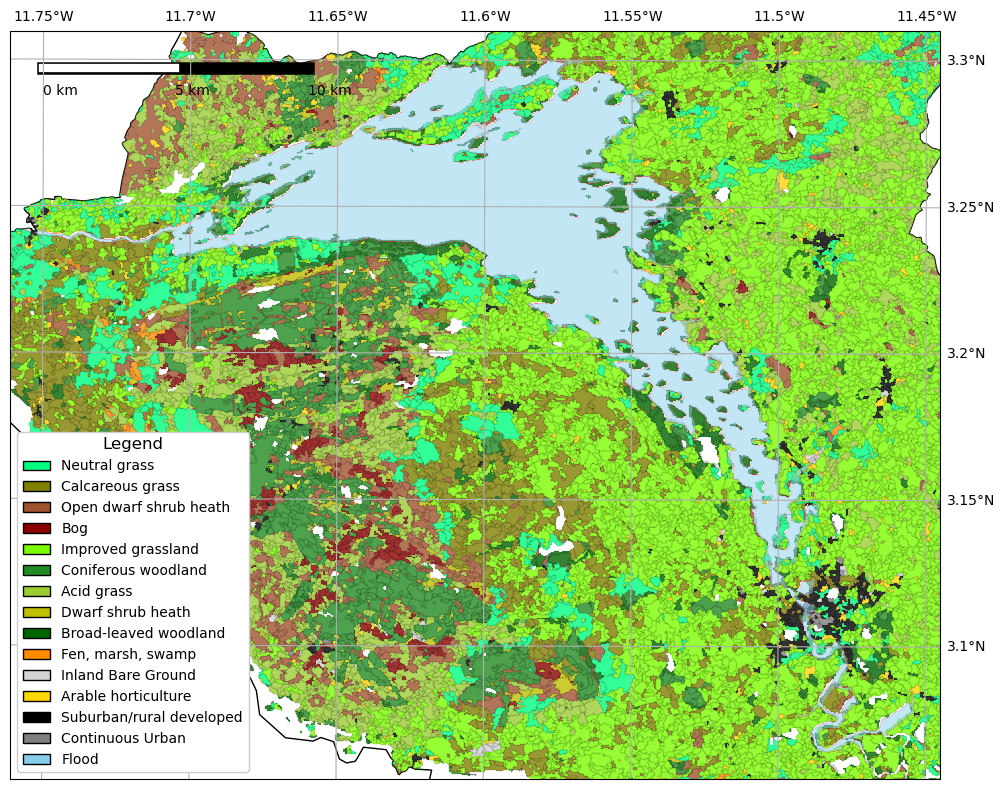

In [17]:
# Add the legend, scale and gridlines to the map and prints the map 
handles = landcover_handles  + flood_handles
labels = landcover + ['Flood']

leg = ax.legend(handles, labels, title='Legend', title_fontsize=12,
                 fontsize=10, loc='lower left', frameon=True, framealpha=1)

gridlines = ax.gridlines(draw_labels=True, alpha=1, edgecolor='k')
                         
gridlines.left_labels = False 
gridlines.bottom_labels = False

scale_bar(ax)

myFig.savefig('land_cover.png')
myFig

In [18]:
# Subset the landcover data using the flood and shows the new dataset
land_cover_flooded = flooded(land_cover) 
land_flooded = land_cover[land_cover_flooded] 
print(land_flooded[['LAND_COVER','Shape_Area']])

                  LAND_COVER  Shape_Area
7799        Continuous Urban     26250.0
7846   Broad-leaved woodland     16250.0
10389  Broad-leaved woodland     18125.0
14105  Broad-leaved woodland     18125.0
14107    Coniferous woodland     27500.0
...                      ...         ...
35196       Continuous Urban      9375.0
35220    Coniferous woodland      6875.0
35258     Inland Bare Ground     13750.0
35260    Coniferous woodland      9375.0
35261  Broad-leaved woodland     10625.0

[135 rows x 2 columns]


In [19]:
# Shows the total flooded area(sqm) of each landcover
land_flooded.groupby(['LAND_COVER'])['Shape_Area'].sum().sort_values(ascending=False)

LAND_COVER
Broad-leaved woodland       767545.0
Coniferous woodland         295000.0
Inland Bare Ground          227500.0
Continuous Urban             82500.0
Open dwarf shrub heath       49554.0
Improved grassland           48750.0
Arable horticulture          36875.0
Neutral grass                20000.0
Suburban/rural developed     19596.0
Calcareous grass             13125.0
Name: Shape_Area, dtype: float64

# Part 3: Infrastructure and population analyses and map

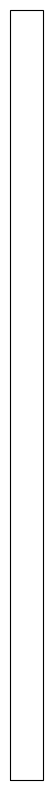

In [20]:
#Create a new figure set to the Irish Transverse Mercato

myCRS = ccrs.UTM(29)

myFig2, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw=dict(projection=myCRS)) 


In [21]:
#Add the flood and Fermanagh county outline and set the extent to the flood polygon
flood_feature = ShapelyFeature(flood['geometry'], myCRS, edgecolor='navy',facecolor='skyblue',alpha=0.5,linewidth=0.5)
ax.add_feature(flood_feature)
xmin, ymin, xmax, ymax = flood.total_bounds
ax.set_extent([xmin-1000, xmax+1000, ymin-1000, ymax+1000], crs=myCRS)


In [22]:
# Add the road shapefile to the map
roads_feature = ShapelyFeature(roads['geometry'], myCRS, edgecolor='gray', linewidth=1.5)
ax.add_feature(roads_feature)


In [23]:
# Add the building shapefile and creates a different label for each CLASSIFICA attribute. Add the different labels to the legend

residential=buildings.loc[buildings['CLASSIFICA']=='Residential']
residential_handle= ax.plot(residential.geometry.x, residential.geometry.y, 's', color='b', ms=1, transform=myCRS)

other=buildings.loc[buildings['CLASSIFICA']=='Other']
other_handle=ax.plot(other.geometry.x, other.geometry.y, 'D', color='limegreen', ms=1, transform=myCRS)

commercial=buildings.loc[buildings['CLASSIFICA']=='Commercial']
commercial_handle=ax.plot(commercial.geometry.x, commercial.geometry.y, 'o', color='turquoise', ms=2, transform=myCRS)

education=buildings.loc[buildings['CLASSIFICA']=='Education']
education_handle=ax.plot(education.geometry.x, education.geometry.y, '^', color='magenta', ms=2, transform=myCRS)

health=buildings.loc[buildings['CLASSIFICA']=='Health']
health_handle=ax.plot(health.geometry.x, health.geometry.y, '*', color='yellow', ms=4, transform=myCRS)


In [24]:
#Add the population density, percentage of children and elderly and small_area shapefile to the map. Change which data is displayed  by removing and adding the #

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1, axes_class=plt.Axes)

small_area_plot=small_area.plot(column='pop_density', ax=ax, k=10,  vmax=1000, cmap='YlOrRd',
                       legend=True, cax=cax, legend_kwds={'label': 'Population Density'})

#small_area_plot=small_area.plot(column='per_elderly', ax=ax, vmax=30, cmap='YlOrRd',
                       #legend=True, cax=cax, legend_kwds={'label': 'Percentage of elderly'})

#small_area_plot=small_area.plot(column='per_children', ax=ax, vmax=30, cmap='YlOrRd',
                       #legend=True, cax=cax, legend_kwds={'label': 'Percentage of children'})

sa_outline = ShapelyFeature(small_area['geometry'], myCRS, edgecolor='r',linewidth=0.05, facecolor='none')
ax.add_feature(sa_outline)
#ax=ax, vmax=1000,

<Figure size 640x480 with 0 Axes>

In [25]:
# Generate the legend label for the road and flood features
roads_handle = [mlines.Line2D([], [], color='gray')]
flood_handle = generate_handles(['Flood'], ['skyblue'])

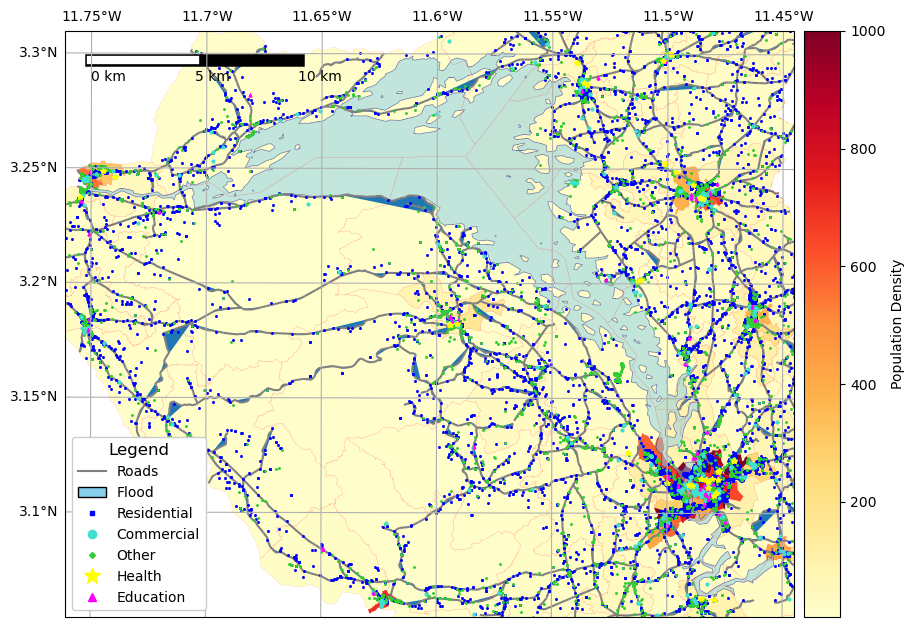

In [26]:
#Add the legend, scale and gridlines to the map. Remove # to print the map
handles = roads_handle  + flood_handle + residential_handle + commercial_handle + other_handle + health_handle + education_handle # use '+' to concatenate (combine) lists
labels = ['Roads'] + ['Flood'] + ['Residential'] + ['Commercial'] + ['Other'] + ['Health'] + ['Education']

leg = ax.legend(handles, labels, title='Legend', title_fontsize=12,
                 fontsize=10, loc='lower left', markerscale=3, frameon=True, framealpha=1)


gridlines = ax.gridlines(draw_labels=True, alpha=1, edgecolor='k') 
                         
gridlines.right_labels = False 
gridlines.bottom_labels = False

scale_bar(ax)


myFig2.savefig('infrastructure_population.png')
myFig2

In [27]:
#Subset the different features using the flood polygon
build_flooded = flooded(buildings) 
building_flooded = buildings[build_flooded] 

rd_flooded = flooded(roads)
roads_flooded = roads[rd_flooded] 

sa_flooded = small_area.sjoin(flood, how="inner") 


In [28]:
# Calculate the total length(in km) of flooded road and A Class road
sum_roads = roads_flooded['Length'].sum() /1000
sum_motorway = roads_flooded[roads_flooded['CLASS'] == 'A']['Length'].sum() /1000
print('{:.2f} total km of roads'.format(sum_roads))
print('{:.2f} total km of A class road'.format(sum_motorway))

2.35 total km of roads
1.18 total km of A class road


In [29]:
# Count the number of flooded buildings 
building_flooded.groupby(['CLASSIFICA'])['CLASSIFICA'].count().sort_values(ascending=False)

CLASSIFICA
Residential    225
Other           70
Commercial      48
Health           2
Name: CLASSIFICA, dtype: int64

In [30]:
# Show which flooded Small Area has the highest population density
high_density= sa_flooded[sa_flooded.pop_density==sa_flooded.pop_density.max()]
print(high_density[['SA2011', 'pop_density']])

        SA2011  pop_density
134  N00003042       3491.0


In [31]:
# Show which Small Area has a high percentage of elderly as well as a high percentage of children
sa_flooded.loc[(sa_flooded['per_elderly']>= sa_flooded['per_elderly'].mean())&(sa_flooded['per_children']>= sa_flooded['per_children'].mean())]



,SA2011,residents,children,elderly,geometry_x,SOA2011,X_COORD,Y_COORD,Hectares,Shape_Leng_left,Shape_Area_left,geometry,pop_density,per_elderly,per_children,index_right,Id,gridcode,Shape_Leng_right,Shape_Area_right
20,N00002928,358,51,61,None,95PP03W1,214376.0,366482.0,3669.440,39025.517718,36656238,"POLYGON ((217257.859 365303.062, 217235.938 36...",10.0,17.04,14.25,0,215,1,273439.84263,1.166912e+08
75,N00002983,320,40,54,None,95PP11W1,223951.0,347032.0,470.688,14713.673226,4706881,"POLYGON ((224111.766 349058.281, 224109.562 34...",68.0,16.88,12.50,0,215,1,273439.84263,1.166912e+08


In [32]:
# Show which Small Area has a low population density but a high percentage of children or a high percentage of elderly
sa_flooded.loc[(sa_flooded['pop_density']<= sa_flooded['pop_density'].mean())&((sa_flooded['per_children']>= sa_flooded['per_children'].mean())|(sa_flooded['per_elderly']>= sa_flooded['per_elderly'].mean()))]


,SA2011,residents,children,elderly,geometry_x,SOA2011,X_COORD,Y_COORD,Hectares,Shape_Leng_left,Shape_Area_left,geometry,pop_density,per_elderly,per_children,index_right,Id,gridcode,Shape_Leng_right,Shape_Area_right
13,N00002921,309,31,52,None,95PP02W1,202346.0,355336.0,8317.0900,62798.682569,83170934,"POLYGON ((206591.234 353513.594, 206598.359 35...",4.0,16.83,10.03,0,215,1,273439.84263,1.166912e+08
17,N00002925,311,43,48,None,95PP03W1,195806.0,358565.0,719.8940,19160.475195,7193502,"POLYGON ((197286.328 359952.875, 197299.969 35...",43.0,15.43,13.83,0,215,1,273439.84263,1.166912e+08
20,N00002928,358,51,61,None,95PP03W1,214376.0,366482.0,3669.4400,39025.517718,36656238,"POLYGON ((217257.859 365303.062, 217235.938 36...",10.0,17.04,14.25,0,215,1,273439.84263,1.166912e+08
21,N00002929,727,101,112,None,95PP03W1,204622.0,362423.0,8855.8100,54964.774354,88465792,"POLYGON ((212900.172 360800.438, 212843.938 36...",8.0,15.41,13.89,0,215,1,273439.84263,1.166912e+08
23,N00002931,628,134,51,None,95PP04W1,224363.0,338169.0,685.7910,17547.814757,6857911,"POLYGON ((223564.562 339903.906, 223559.672 33...",92.0,8.12,21.34,0,215,1,273439.84263,1.166912e+08
42,N00002952,326,36,56,None,95PP06S2,225564.0,343326.0,321.8980,12351.202175,3218980,"POLYGON ((226659.703 344481.781, 226657.734 34...",101.0,17.18,11.04,0,215,1,273439.84263,1.166912e+08
47,N00002955,438,62,65,None,95PP07W1,211844.0,355895.0,5440.6500,43409.947426,54406504,"POLYGON ((214762.625 357207.594, 214790.938 35...",8.0,14.84,14.16,0,215,1,273439.84263,1.166912e+08
64,N00002972,287,37,27,None,95PP09W1,222522.0,346501.0,335.4060,10246.747423,3354058,"POLYGON ((223045.547 347631.688, 223045.297 34...",86.0,9.41,12.89,0,215,1,273439.84263,1.166912e+08
75,N00002983,320,40,54,None,95PP11W1,223951.0,347032.0,470.6880,14713.673226,4706881,"POLYGON ((224111.766 349058.281, 224109.562 34...",68.0,16.88,12.50,0,215,1,273439.84263,1.166912e+08
92,N00003003,1353,185,203,None,95PP14S2,217191.0,360962.0,3556.0800,40517.946857,35560819,"POLYGON ((218715.750 363219.844, 218715.969 36...",38.0,15.00,13.67,0,215,1,273439.84263,1.166912e+08
